In [ ]:
!git clone https://github.com/CPShub/LecturePhysicsAwareML
!pip install diffrax

fatal: destination path 'NeuralODE_JAX' already exists and is not an empty directory.


# Tutorial: Neural Ordinary Differential Equations

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Dr. rer. nat. Oliver Weeger, Dr.-Ing. Maximilian Kannapinn

Content creators: Kartikay Awasthi, Fabian Roth, Dr.-Ing. Maximilian Kannapinn

Summer term 2024

---

#### In this notebook, you learn...

* Set up an augmented neural ODE class in Google JAX with user-defined augmentation
* Import the non-linear Euler-Bernoulli beam training data generated with *nlebb_dynamic_batch.m*
* Set up training parameters and training loop in JAX
* Calibrate the neural ODE on dedicated data sets
* Test the model during calibration to avoid over-fitting
* Check for generalization at the end with unseen data sets



*Run the following cells to install and import the required dependencies.*

In [ ]:
# %% Imports
import time
import numpy
import numpy as np
import diffrax
from diffrax import backward_hermite_coefficients, CubicInterpolation
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
import os
import numpy as np

## Introduction to Neural Ordinary Differential Equations (Neural ODEs)

### Ordinary Differential Equations (ODEs)

Ordinary Differential Equations (ODEs) are equations that describe the relationship between a function and its derivatives and are typically written in the form:
$$
\frac{dy(t)}{dt} = f(t, y(t))
$$
where $y(t)$ is the state of the system at time $t$, and $f(t, y(t))$ is a function that describes the dynamics of the system.

### Neural Ordinary Differential Equations (NODEs)

Neural ODEs use a feed-forward neural network to parameterize the function $f$ of an ordinary differential equation.

Given an initial state $ y(t_0) = y_0$, the evolution of the state over time can be described by solving the ODE:

$$ y(t) = y_0 + \int_{t_0}^{t} f(y(t), t, \theta) dt$$

where $\theta$ represents the parameters of the neural network, and $y_0 \in \mathbb{R}^n$.

Simply put, the right hand side $f$ of the ODE accepts the current state $y(t)$ of the ODE at current time $t$ and parameters $\theta$, to give an output that has the same shape as $y(t)$.

Let's take a look at how to define such a class of machine learning models using Google JAX:

In [ ]:
class NeuralODE(eqx.Module):
    mlp: eqx.nn.MLP
    time_dependent: bool
    state_size: int
    augmentation_size: int
    input_size: int

    def __init__(self, state_size, augmentation_size=0, input_size=0, time_dependent=False, nn_width=16, nn_depth=2, *, key, **kwargs):
        super().__init__(**kwargs)
        nn_in_size = state_size + augmentation_size + input_size + time_dependent
        nn_out_size = state_size + augmentation_size

        self.state_size = state_size
        self.time_dependent = time_dependent
        self.augmentation_size = augmentation_size
        self.input_size = input_size

        self.mlp = eqx.nn.MLP(
            in_size=nn_in_size,
            out_size=nn_out_size,
            width_size=nn_width,
            depth=nn_depth,
            activation=jax.nn.softplus,
            key=key,
        )

    def __call__(self, ts, y0, us):
        y0 = jnp.pad(y0, (0, self.augmentation_size))  # Pad the state vector with zeros in augmented dimensions

        if self.input_size:
            coeffs = diffrax.backward_hermite_coefficients(ts, us)
            interp = diffrax.CubicInterpolation(ts, coeffs)  # Interpolation of data between timesteps
        else:
            interp = None

        def func(t, y, args):
            interp = args
            if self.input_size:
                u = interp.evaluate(t)
            else:
                u = jnp.empty(shape=(0,))

            if self.time_dependent:
                t = jnp.expand_dims(t, axis=0)
            else:
                t = jnp.empty(shape=(0,))

            nn_input = jnp.concatenate([y, u, t], axis=0)
            return self.mlp(nn_input)

        term = diffrax.ODETerm(func)
        solution = diffrax.diffeqsolve(
            term,
            solver=diffrax.Dopri5(),
            t0=ts[0], t1=ts[-1],
            dt0=ts[1] - ts[0], y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
            args=interp
        )
        return solution.ys[:, :self.state_size]

In the above, we have defined, a neural ODE model. The right-hand side is modeled by a multi-layer perceptron (MLP) that adapts to the size of the data that is being provided and the desired augmentation (if any).


We are using a Dormand-Prince ODE solver, which is an adaptive step-size solver. The adaptive step size control is achieved using a PID controller where the relative tolerance (`rtol`) and absolute tolerance (`atol`). The PID controller can further be tweaked using the PID coefficients (`pcoeff`, `icoeff` and `dcoeff`) or even by adding minimum and maximum step size (`dtmin` and `dtmax`)

Interpolation of training data is required, as the adaptive step-size solver may evaluate at times different from the sampling times within MATLAB.



## Data Preparation

A parameter-sweep is performed on the non-linear Euler-Bernoulli beam model on MATLAB to generate data for training, see *nlebb_dynamic_batch.m*. For each parameter combination, it outputs a folder containing a excitation force trajectory (*..._exc.csv*) and the output of all nodes (*..._out.csv*). Each data set can be identified with a unique ID.

The following function imports the necessary data and prepares it to be used with the model, for training and inference.

In [ ]:
# Accepts the index of the file to be used for training and the nodes to be used for training
def dataprep(datafile, node):

    def create_path(i):
        filename = [filename for filename in os.listdir('LecturePhysicsAwareML/NeuralODE/nlebb-training-data/') if filename.startswith(str(i))][0]
        path1 = "LecturePhysicsAwareML/NeuralODE/nlebb-training-data/"
        path2 = filename

        return path1 + path2 + "/" + path2 + "_exc.csv", path1 + path2 + "/" + path2 + "_out.csv"


    def load_data(data_list, nodes):
        inp = np.empty((len(data_list), 2502, 2))
        out = np.empty((len(data_list), 2502, len(nodes)))

        for i in range(len(data_list)):
            exc, outt = create_path(data_list[i])
            inp[i] = np.loadtxt(open(exc), delimiter=',', skiprows=1)
            out[i] = np.loadtxt(open(outt), delimiter=',', skiprows=1, usecols=(nodes)).reshape(2502, len(nodes))
        return inp, out

    inp_tr, out_tr = load_data(datafile, node)
    us = np.expand_dims(inp_tr[:, :, 1],-1)               # Stores excitation force from the _exc.csv
    ys = out_tr                                           # Displacement and their derivatives of all nodes
    ts = inp_tr[:, :, 0]                                  # Stores time steps from _exc.csv
    ts = np.squeeze(ts[0])                                # Timesteps are squeezed into a 1D array
    return us, ys, ts

Further, let's also define the dataloader and functions that obtain loss, gradient and update the weights accordingly.

In [ ]:
# Provides flexibility to use training data as whole or in batches
def _dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = min(batch_size, dataset_size)
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

# The eqx.filter_jit function transforms the assigned functions to be compiled just-in-time.
# It is a method for adaptive optimization that enables faster runtime for functions that are used iteratively.
# The get_loss function simple accepts the model and initial state, and returns the error between the predicted and actual data.
# Currently used error metric: RMSE (Root Mean Squared Error)
@eqx.filter_jit
def get_loss(model, ti, yi, ui):
    y_pred = jax.vmap(model, in_axes=(None, 0, 0))(ti, yi[:, 0], ui)
    return jnp.sqrt(jnp.mean((yi - y_pred) ** 2))

# The eqx.filter_value_and_grad() wraps the get_loss() function, allowing us to calculate the value and gradient of the loss function.
grad_loss = eqx.filter_value_and_grad(get_loss)

# make_step performs gradient descent and updates model parameters
@eqx.filter_jit
def make_step(ti, yi, ui, model, optim, opt_state):
    loss, grads = grad_loss(model, ti, yi, ui)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

# Defines the training loop based on model parameters that are defined
def train(
    model,
    training_data,
    key,
    validation_data,
    batch_size=32,
    lr_strategy=(3e-3, 1e-3),
    steps_strategy=(500, 1000),
    length_strategy=(0.1, 1),
    print_every=100,):

    ts, ys, us = training_data
    vts, vys, vus = validation_data

    num_ts = ts.shape[0]
    losses = []
    val_losses = []

    start_time = time.time()
    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[:   int(num_ts * length)]
        _ys = ys[:, :int(num_ts * length)]
        _us = us[:, :int(num_ts * length)]
        _vts = vts[:   int(num_ts * length)]
        _vys = vys[:, :int(num_ts * length)]
        _vus = vus[:, :int(num_ts * length)]
        for step, (yi, ui) in zip(
            range(steps), _dataloader((_ys, _us), batch_size, key=key)
        ):
            loss, model, opt_state = make_step(_ts, yi, ui, model, optim, opt_state)
            val_loss = get_loss(model, _vts, _vys, _vus)
            losses.append(loss)
            val_losses.append(val_loss)
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss:.3e}, Val Loss: {val_loss:.3e}")
    training_time = time.time() - start_time
    print(f'Training took: {training_time:-2f}s')

    return model, losses, val_losses

We can now define the parameters for the model and its training.
For now, we set aug_dim = 0, which means no augmentations will take place.

In [ ]:
datafile = [2100]                    # Indices of the files to be used for training
node = [34, 36]                                     # The displacement of the node and its derivative w.r.t time
aug_dim = 0                                         # Since it is a neural ODE, no augmented dimensions
hidden_layers = 2
hidden_dims = 32
learning_rate = 0.001
Epochs = 30000
print_every = 100                                   # Loss displayed after set number of steps during training
validation_dataset = np.arange(2100, 2136, 1)       # To gauge accuracy of generalization, the model is validated over the entire dataset every epoch
optim = optax.adabelief(learning_rate)              # AdaBelief Optimizer. Read more at - proceedings.neurips.cc/paper/2020/file/d9d4f495e875a2e075a1a4a6e1b9770f-Paper.pdf
seed = 42                                           # Seed for a pseudo-random function which initializes parameters of the neural network

In [ ]:
us, ys, ts = dataprep(datafile, node)                         # Training data
us_val, ys_val, ts_val = dataprep(validation_dataset, node)   # Validation data
num_ts = ts.size                                              # Stores total number of time steps (for data)
key = jr.PRNGKey(seed)                                        # Generate a key from a seed for the model
model_key, key = jr.split(key, 2)

The model can now be trained:

In [ ]:
model = NeuralODE(state_size=ys.shape[-1],
                      input_size=us.shape[-1],
                      time_dependent=False,
                      nn_width=hidden_dims, nn_depth=hidden_layers,
                      key=model_key)                                         # The model is defined with random weights generated using the key
model, losses, val_losses = train(
        model, (ts, ys, us), key,
        validation_data=(ts_val, ys_val, us_val), batch_size=len(ys),
        steps_strategy=(Epochs,), length_strategy=(0.5, ),
        lr_strategy=(learning_rate, )                                        # Data is passed to the train() function, executing the training loop
    )

Step: 0, Loss: 2.692e-01, Val Loss: 1.613e-01
Step: 100, Loss: 3.753e-03, Val Loss: 5.422e-01
Step: 200, Loss: 3.958e-03, Val Loss: 5.434e-01
Step: 300, Loss: 3.815e-03, Val Loss: 5.401e-01
Step: 400, Loss: 3.877e-03, Val Loss: 5.420e-01
Step: 500, Loss: 4.266e-03, Val Loss: 5.422e-01
Step: 600, Loss: 3.269e-03, Val Loss: 5.343e-01
Step: 700, Loss: 2.650e-03, Val Loss: 5.371e-01
Step: 800, Loss: 2.494e-03, Val Loss: 5.409e-01
Step: 900, Loss: 2.414e-03, Val Loss: 5.395e-01
Step: 1000, Loss: 2.369e-03, Val Loss: 5.437e-01
Step: 1100, Loss: 2.493e-03, Val Loss: 5.435e-01
Step: 1200, Loss: 2.625e-03, Val Loss: 5.432e-01
Step: 1300, Loss: 2.546e-03, Val Loss: 5.438e-01
Step: 1400, Loss: 2.536e-03, Val Loss: 5.381e-01
Step: 1500, Loss: 2.756e-03, Val Loss: 5.335e-01
Step: 1600, Loss: 2.620e-03, Val Loss: 5.220e-01
Step: 1700, Loss: 2.449e-03, Val Loss: 5.146e-01
Step: 1800, Loss: 2.598e-03, Val Loss: 5.120e-01
Step: 1900, Loss: 2.518e-03, Val Loss: 5.040e-01
Step: 2000, Loss: 2.654e-03, Val

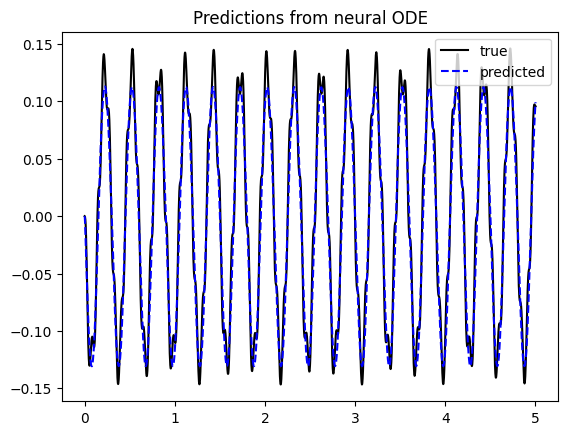

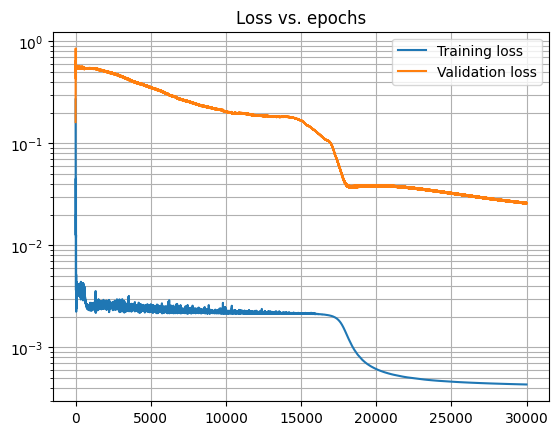

In [ ]:
testset = [2118]
tus, tys, tts = dataprep(testset, node)
y_pred = jax.vmap(model, in_axes=(None, 0, 0))(tts, tys[:, 0], tus)

plt.figure()
plt.plot(tts, tys[0, :, 0], color='black', label='true', alpha = 1)
plt.plot(tts , y_pred[0, :, 0], color='blue', label='predicted', linestyle = '--')
plt.legend()
plt.title('Predictions from neural ODE')
plt.show()

plt.figure()
plt.semilogy(losses, label="Training loss")
plt.semilogy(val_losses, label = "Validation loss")
plt.legend()
plt.grid(which = 'both')
plt.title("Loss vs. epochs")
plt.show()


In [ ]:
# Generalization check
newpath = 'LecturePhysicsAwareML/NeuralODE/Results/neuralODE/'
if not os.path.exists(newpath):
    os.makedirs(newpath)
te = np.arange(2100, 2136, 1)
for i in range (len(te)):
    plt.figure()
    ttus, ttys, ttts = dataprep([te[i]], node)
    ty_pred = jax.vmap(model, in_axes=(None, 0, 0))(ttts, ttys[:, 0], ttus)
    plt.plot(ttts, ttys[0, :, 0], color='black', label='true', alpha = 1)
    plt.plot(ttts , ty_pred[0, :, 0], color='blue', label='predicted', linestyle = '--')
    plt.legend()
    plt.title('Predictions from neural ODE')
    plt.savefig(f"{newpath}trAllte{te[i]}.png")
    plt.close()


## Augmented Neural Ordinary Differential Equations (ANODE)

Augmented Neural ODEs introduce additional dimensions to the state vector. This augmentation allows the model to learn more complex dynamics and capture finer details. This is achieved by allowing the trajectories to "flow" into the augmented dimensions.

If the original state is $ y(t) \in \mathbb{R}^n$, the augmented state is $(y(t), I(t) \in \mathbb{R}^{n+m}$, where $ I(t)$ represents the additional dimensions.  Hence, the general form of an augmented neural ODE can be written as:

$$ \frac{d}{dt} \begin{pmatrix} y(t) \\ I(t) \end{pmatrix} = f\left( t, \begin{pmatrix} y(t) \\ I(t) \end{pmatrix}, \theta \right)$$

The initial augmented state $ (y(t_0), I(t_0)) $ is typically initialized with $ I(t_0) = 0 $ or some other values that reflect prior knowledge about the system.


### Definition of an augmented neural ODE model

Similar to NODEs, we now define the parameters for the model and training, with an additional parameter (`aug_dim = 1`) for augmented dimensions.

In [ ]:
datafile = [2100]                 # Indices of the files to be used for training
node = [34, 36]                                     # The displacement of the node and its derivative w.r.t time
aug_dim = 1                                         # Augmented dimensions to the hidden state
hidden_layers = 2
hidden_dims = 32
learning_rate = 0.001
Epochs = 30000
print_every = 100                                   # Loss displayed after set number of steps during training
validation_dataset = np.arange(2100, 2136, 1)       # To gauge accuracy of generalization, the model is validated over the entire dataset every epoch
optim = optax.adabelief(learning_rate)              # AdaBelief Optimizer. Read more at - proceedings.neurips.cc/paper/2020/file/d9d4f495e875a2e075a1a4a6e1b9770f-Paper.pdf
seed = 42                                           # Seed for a pseudo-random function which initializes parameters of the Neural Network

In [ ]:
us, ys, ts = dataprep(datafile, node)                         # Training data
us_val, ys_val, ts_val = dataprep(validation_dataset, node)   # Validation data
num_ts = ts.size                                              # Stores total number of time steps (for data)
key = jr.PRNGKey(seed)                                        # Generate a key from a seed for the model
model_key, key = jr.split(key, 2)

In [ ]:
model = NeuralODE(state_size=ys.shape[-1],
                      input_size=us.shape[-1],
                      time_dependent=False,
                      nn_width=hidden_dims, nn_depth=hidden_layers,
                      key=model_key, augmentation_size=aug_dim)       # The model is defined with random weights generated using the key
model, losses, val_losses = train(
        model, (ts, ys, us), key,
        validation_data=(ts_val, ys_val, us_val), batch_size=len(ys),
        steps_strategy=(Epochs,), length_strategy=(0.5, ),
        lr_strategy=(learning_rate, )
    )                                                                # Data is passed to the train() function, executing the training loop

Step: 0, Loss: 4.117e-01, Val Loss: 4.738e-01
Step: 100, Loss: 4.339e-03, Val Loss: 3.943e-01
Step: 200, Loss: 5.688e-03, Val Loss: 3.424e-01
Step: 300, Loss: 7.361e-03, Val Loss: 3.446e-01
Step: 400, Loss: 3.827e-03, Val Loss: 3.348e-01
Step: 500, Loss: 5.218e-03, Val Loss: 3.020e-01
Step: 600, Loss: 6.450e-03, Val Loss: 3.030e-01
Step: 700, Loss: 3.501e-03, Val Loss: 3.048e-01
Step: 800, Loss: 3.968e-03, Val Loss: 2.901e-01
Step: 900, Loss: 2.665e-03, Val Loss: 2.751e-01
Step: 1000, Loss: 2.612e-03, Val Loss: 2.655e-01
Step: 1100, Loss: 2.558e-03, Val Loss: 2.617e-01
Step: 1200, Loss: 2.547e-03, Val Loss: 2.557e-01
Step: 1300, Loss: 2.544e-03, Val Loss: 2.535e-01
Step: 1400, Loss: 2.494e-03, Val Loss: 2.538e-01
Step: 1500, Loss: 2.490e-03, Val Loss: 2.497e-01
Step: 1600, Loss: 2.494e-03, Val Loss: 2.504e-01
Step: 1700, Loss: 2.503e-03, Val Loss: 2.499e-01
Step: 1800, Loss: 2.493e-03, Val Loss: 2.486e-01
Step: 1900, Loss: 2.470e-03, Val Loss: 2.475e-01
Step: 2000, Loss: 2.442e-03, Val

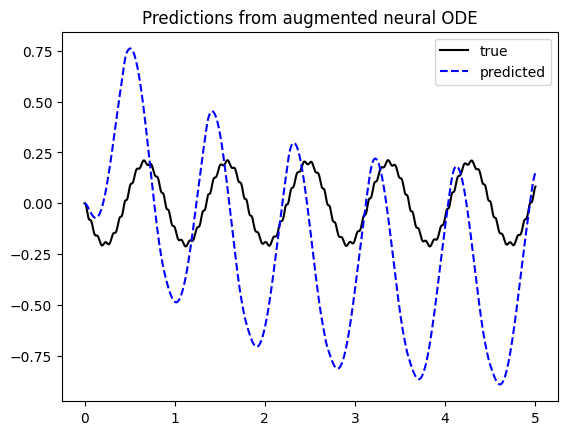

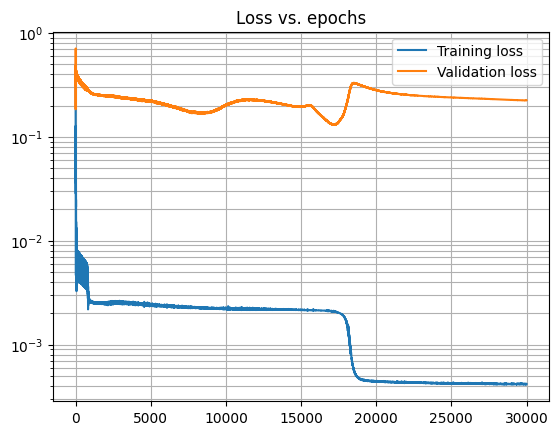

In [ ]:
testset = [2132]
tus, tys, tts = dataprep(testset, node)
y_pred = jax.vmap(model, in_axes=(None, 0, 0))(tts, tys[:, 0], tus)

plt.figure()
plt.plot(tts, tys[0, :, 0], color='black', label='true', alpha = 1)
plt.plot(tts , y_pred[0, :, 0], color='blue', label='predicted', linestyle = '--')
plt.legend()
plt.title('Predictions from augmented neural ODE')
plt.show()

plt.figure()
plt.semilogy(losses, label="Training loss")
plt.semilogy(val_losses, label = "Validation loss")
plt.legend()
plt.grid(which = 'both')
plt.title("Loss vs. epochs")
plt.show()

In [ ]:
newpath = f'LecturePhysicsAwareML/NeuralODE/Results/Aug{aug_dim}neuralODE/'
if not os.path.exists(newpath):
    os.makedirs(newpath)
te = np.arange(2100, 2136, 1)
for i in range (len(te)):
    plt.figure()
    ttus, ttys, ttts = dataprep([te[i]], node)
    ty_pred = jax.vmap(model, in_axes=(None, 0, 0))(ttts, ttys[:, 0], ttus)
    plt.plot(ttts, ttys[0, :, 0], color='black', label='true', alpha = 1)
    plt.plot(ttts , ty_pred[0, :, 0], color='blue', label='predicted', linestyle = '--')
    plt.legend()
    plt.title('Predictions from Neural ODE')
    plt.savefig(f"{newpath}trAllte{te[i]}.png")
    plt.close()
